In [123]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader, TensorDataset

In [124]:
# For simple regression problem
TRAINING_POINTS = 1000

In [125]:
# With this block, we don't need to set device=DEVICE for every tensor.
# But you will still need to avoid accidentally getting int types instead of floating-point types.
torch.set_default_dtype(torch.float32)
if torch.cuda.is_available():
     torch.set_default_device(0)
     print("Running on the GPU")
else:
     print("Running on the CPU")

Running on the CPU


In [126]:
def create_linear_training_data():
    """
    This method simply rotates points in a 2D space.
    Be sure to use MSE in the place of the final softmax layer before testing on this
    data!
    :return: (x,y) the dataset. x is a torch tensor where columns are training samples and
             y is a torch tensor where each column is an output sample, rotated 90 degrees 
             in 2d space from the input point. 
    """
    x = torch.randn((2, TRAINING_POINTS))
    x1 = x[0:1, :].clone()
    x2 = x[1:2, :]
    y = torch.cat((-x2, x1), axis=0)
    return x.T, y.T

In [127]:
def create_folded_training_data():
    """
    This method introduces a single non-linear fold into the sort of data created by create_linear_training_data.
    Be sure to use MSE in the place of the final softmax layer before testing on this
    data!
    :return: (x,y) the dataset. x is a torch tensor where columns are training samples and
             y is a torch tensor where columns output samples. 
    """
    x = torch.randn((2, TRAINING_POINTS))
    x1 = x[0:1, :].clone()
    x2 = x[1:2, :]
    x2 *= 2 * ((x2 > 0).float() - 0.5)
    y = torch.cat((-x2, x1), axis=0)
    return x, y

In [128]:
def create_square():
    """
    This is a square example in which the challenge is to determine
    if the points are inside or outside of a square in 2d space.
    insideness is true if the points are inside the square.
    :return: (points, insideness) the dataset. points is a 2xN array of points and insideness is true if the point is inside the square.
    """
    win_x = [2,2,3,3]
    win_y = [1,2,2,1]
    win = torch.tensor([win_x,win_y],dtype=torch.float32)
    win_rot = torch.cat((win[:,1:],win[:,0:1]),axis=1)
    t = win_rot - win # edges tangent along side of poly
    rotation = torch.tensor([[0, 1],[-1,0]],dtype=torch.float32)
    normal = rotation @ t # normal vectors to each side of poly
        # torch.matmul(rotation,t) # Same thing

    points = torch.rand((2,2000),dtype = torch.float32)
    points = 4*points

    vectors = points[:,np.newaxis,:] - win[:,:,np.newaxis] # reshape to fill origin
    insideness = (normal[:,:,np.newaxis] * vectors).sum(axis=0)
    insideness = insideness.T
    insideness = insideness > 0
    insideness = insideness.all(axis=1)
    return points, insideness

In [129]:
def relu(x):
    return torch.maximum(x, torch.tensor(0.0))

In [130]:
def compute_loss(Y_pred, Y_true, W1, W2, lambda_l2):
    """Computes MSE loss with L2 regularization."""
    mse_loss = torch.mean((Y_pred - Y_true) ** 2)
    l2_reg = lambda_l2 * (torch.sum(W1 ** 2) + torch.sum(W2 ** 2))
    return mse_loss + l2_reg

In [ ]:
if __name__ == '__main__':
    # For this week's lab, you can likely keep ALL your code
    # right here, with all your variables in the global scope 
    # for simplified debugging.
    #
    # The code in this section should NOT be in a helper method.
    # Similarly, the output of each sub-layer and activation function should
    # be in this scope.

    # TODO: You may wish to make each TODO below its own pynb cell.
    # TODO: Build your network.
    # Hyperparameters
    lambda_l2 = 0.001  # Lower L2 regularization for better generalization
    learning_rate = 0.01  # Prevent instability from high learning rate
    num_epochs = 40
    batch_size = 32 

    # Initialize network parameters
    input_dim = 2
    hidden_dim = 3
    output_dim = 2

    W1 = torch.randn(input_dim, hidden_dim) * 0.1  # Normal distribution 
    b1 = torch.zeros(hidden_dim)  # Zero bias
    W2 = torch.randn(hidden_dim, output_dim) * 0.1  # Normal distribution 
    b2 = torch.zeros(output_dim)  # Zero bias

    W1.requires_grad = True
    b1.requires_grad = True
    W2.requires_grad = True
    b2.requires_grad = True

    # Create training data
    x_train, y_train = create_linear_training_data()
    x_test, y_test = create_linear_training_data()  

    # Create dataloader for batch processing
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    training_loss = []
    test_loss = []

    print("Training...")
    for epoch in range(num_epochs):
        epoch_loss = 0

        for batch_x, batch_y in train_loader:
            # Forward pass
            Z1 = batch_x @ W1 + b1  
            A1 = relu(Z1)           
            Z2 = A1 @ W2 + b2  
            Y_pred = Z2  

            # Compute loss
            total_loss = compute_loss(Y_pred, batch_y, W1, W2, lambda_l2)
            epoch_loss += total_loss.item()

            # Backward pass
            total_loss.backward()

            # Update weights using gradient descent
            with torch.no_grad():
                W1 -= learning_rate * W1.grad
                b1 -= learning_rate * b1.grad
                W2 -= learning_rate * W2.grad
                b2 -= learning_rate * b2.grad

                # Reset gradients
                W1.grad.zero_()
                b1.grad.zero_()
                W2.grad.zero_()
                b2.grad.zero_()

        # store epoch loss
        training_loss.append(epoch_loss / len(train_loader))

        # compute test loss
        Z1_test = x_test @ W1 + b1  
        A1_test = relu(Z1_test)
        Z2_test = A1_test @ W2 + b2
        Y_pred_test = Z2_test  
        test_loss.append(compute_loss(Y_pred_test, y_test, W1, W2, lambda_l2).item())


        print(f"Epoch {epoch}, Training Loss: {epoch_loss / len(train_loader)}")

    # Test the model
    Z1_test = x_test @ W1 + b1
    A1_test = relu(Z1_test)
    Z2_test = A1_test @ W2 + b2
    Y_pred_test = Z2_test

    print("\nFinal Training Loss:", training_loss[-1])
    print("Final Test Loss:", compute_loss(Y_pred_test, y_test, W1, W2, lambda_l2).item())
    print("Predicted Test Output (first 5):", Y_pred_test[:5]) 
    print("True Test Output (first 5):", y_test[:5])  

    # Compute W * M as per lab assignment
    WM = W1 @ W2  
    print("Computed W * M:", WM)

    pass 

Training...
Epoch 0, Training Loss: 1.0402159094810486
Epoch 1, Training Loss: 1.0077448729425669
Epoch 2, Training Loss: 0.9952698461711407
Epoch 3, Training Loss: 0.980058241635561
Epoch 4, Training Loss: 0.9719605036079884
Epoch 5, Training Loss: 0.957145543769002
Epoch 6, Training Loss: 0.9221312198787928
Epoch 7, Training Loss: 0.8888150630518794
Epoch 8, Training Loss: 0.8333533406257629
Epoch 9, Training Loss: 0.7742444928735495
Epoch 10, Training Loss: 0.7073599752038717
Epoch 11, Training Loss: 0.6305689550936222
Epoch 12, Training Loss: 0.5646423613652587
Epoch 13, Training Loss: 0.4805043274536729
Epoch 14, Training Loss: 0.3991786655969918
Epoch 15, Training Loss: 0.33914295630529523
Epoch 16, Training Loss: 0.27519425516948104
Epoch 17, Training Loss: 0.23103402415290475
Epoch 18, Training Loss: 0.1952054927824065
Epoch 19, Training Loss: 0.15977946831844747
Epoch 20, Training Loss: 0.13270296342670918
Epoch 21, Training Loss: 0.12031171610578895
Epoch 22, Training Loss: 0

#### Discussion
Observing the final training and testing loss, we can see that the model trained quite well, obtaining a final test MSE of ~0.03. Subsequently, the transformation matrix of W1*W2 follows a similar pattern to a 90 degree transformation matrix (minus rounding). With these two observations, it is safe to say that the model is able to learn the transformation matrix of a 90 degree rotation.


### Plot Training and Test loss

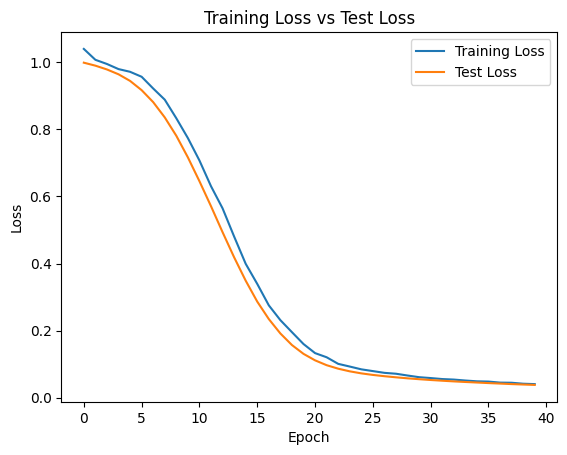

In [132]:
import matplotlib.pyplot as plt
plt.plot(training_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.title('Training Loss vs Test Loss')
plt.legend()
plt.show()


### Test 1
Output should be [0.2185, 0.027], J should be 0.18101

In [133]:
X = torch.tensor([[0.105, 0.815]])  
W1 = torch.tensor([[0.75, -0.55, 0.25], [0.25, -0.75, -0.15]], requires_grad=True)
b1 = torch.tensor([-0.1, 0.2, -0.3], requires_grad=True)  
W2 = torch.tensor([[0.1, -0.4], [-0.2, 0.5], [0.3, -0.6]], requires_grad=True)  
b2 = torch.tensor([0.2, 0.1], requires_grad=True)  
Y_true = torch.tensor([[0.815, 0.105]])
lambda_l2 = 0.001


In [134]:
Z1 = X @ W1 + b1
A1 = relu(Z1) 
Z2 = A1 @ W2 + b2
Y_pred = Z2  
mse_loss = torch.mean((Y_pred - Y_true) ** 2)
l2_reg = lambda_l2/2 * (torch.sum(W1)**2 + torch.sum(W2)**2)
total_loss = mse_loss + l2_reg

print("Predicted Output (Y_pred):", Y_pred)
print("True Output (Y_true):", Y_true)
print("MSE Loss:", mse_loss.item())
print("L2 Regularization Loss:", l2_reg.item())
print("Total Loss (MSE + L2 Regularization):", total_loss.item())

Predicted Output (Y_pred): tensor([[0.2183, 0.0270]], grad_fn=<AddBackward0>)
True Output (Y_true): tensor([[0.8150, 0.1050]])
MSE Loss: 0.18109728395938873
L2 Regularization Loss: 6.500001472886652e-05
Total Loss (MSE + L2 Regularization): 0.1811622828245163


These values are very close to the output and loss I calculated by hand. The small differences are due to the rounding I did by hand.

## Test 2

Output should be [-2.0, 0.5]. J should be 2.215.

In [135]:
X = torch.tensor([[1.0, 0.0]])  
W1 = torch.tensor([[1.0, 0.0, 1.0], [0.0, 1.0, 0.0]], requires_grad=True)
b1 = torch.tensor([.5, .5, .5], requires_grad=True)  
W2 = torch.tensor([[-1.0, 0.0], [0.0, -1.0], [-1.0, 0.0]], requires_grad=True)  
b2 = torch.tensor([1.0, 1.0], requires_grad=True)  
Y_true = torch.tensor([[0.0, 1.0]])
lambda_l2 = 0.01

In [136]:
Z1 = X @ W1 + b1
A1 = relu(Z1) 
Z2 = A1 @ W2 + b2
Y_pred = Z2  
mse_loss = torch.mean((Y_pred - Y_true) ** 2)
l2_reg = lambda_l2/2 * (torch.sum(W1)**2 + torch.sum(W2)**2)
total_loss = mse_loss + l2_reg

print("Predicted Output (Y_pred):", Y_pred)
print("True Output (Y_true):", Y_true)
print("MSE Loss:", mse_loss.item())
print("L2 Regularization Loss:", l2_reg.item())
print("Total Loss (MSE + L2 Regularization):", total_loss.item())

Predicted Output (Y_pred): tensor([[-2.0000,  0.5000]], grad_fn=<AddBackward0>)
True Output (Y_true): tensor([[0., 1.]])
MSE Loss: 2.125
L2 Regularization Loss: 0.08999999612569809
Total Loss (MSE + L2 Regularization): 2.2149999141693115


These values are very close to the output and loss I calculated by hand. The small differences are due to the rounding I did by hand.